---

### **Time Series Forecasting for Electric and Gas Utilities' Industrial Production**

---

#### **Background:**
This project utilizes data from the Board of Governors of the Federal Reserve System's G.17 Industrial Production and Capacity Utilization release. This dataset provides valuable insights into the industrial sector's output, encompassing manufacturing, mining, and utilities, which serves as a key economic performance indicator.

#### **Dataset Overview:**
The provided dataset measures the real output of electric and gas utility industries in the United States, indexed to a base year of 2017 (2017=100). The data is presented in monthly intervals and is not seasonally adjusted, meaning it reflects raw production levels without accounting for seasonal fluctuations, such as weather-related changes.

#### **Objective:**
Our objective is to develop an ARIMA model using the provided dataset to forecast future production units and simulate production levels for prospective requirements, enabling informed decision-making and planning in the electric and gas utilities sector.

#### **Additional Details**
For more information on the dataset, please refer to the Federal Reserve Economic Data (FRED) website, specifically the series "Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)" with the identifier IPG2211A2N.

**Dataset link:**

https://fred.stlouisfed.org/series/IPG2211A2N


---

#### **Importing Libraries**

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


---

#### **Loading Dataset**

---

In [2]:
# df_train = pd.read_csv("/content/drive/MyDrive/IPG2211A2N.csv")
df = pd.read_csv("IPG2211A2N.csv")
df


,observation_date,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608
...,...,...
1026,2024-07-01,120.0696
1027,2024-08-01,118.3836
1028,2024-09-01,103.6557
1029,2024-10-01,95.9600


---

#### **Exploratory Data Analysis**

---

In [3]:
# What is the shape of the data? i.e. Number of Rows and Columns

df.shape


(1031, 2)

In [4]:
# How many total values in each columns?
# How many null values?
# What is the data types of each column?

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  1031 non-null   object 
 1   IPG2211A2N        1031 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [5]:
# How many unique values are available in each column?

df.apply(lambda x: x.nunique())


observation_date    1031
IPG2211A2N           962
dtype: int64

In [6]:
# Let's convert the observation_date column to datetime format

df['Date'] = pd.to_datetime(df['observation_date'])
df.drop(['observation_date'], axis=1, inplace=True)

df

,IPG2211A2N,Date
0,3.3336,1939-01-01
1,3.3591,1939-02-01
2,3.4354,1939-03-01
3,3.4608,1939-04-01
4,3.4608,1939-05-01
...,...,...
1026,120.0696,2024-07-01
1027,118.3836,2024-08-01
1028,103.6557,2024-09-01
1029,95.9600,2024-10-01


In [7]:
# Let's set Date column as index column

df.set_index('Date', inplace=True)

df

,IPG2211A2N
Date,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4608
1939-05-01,3.4608
...,...
2024-07-01,120.0696
2024-08-01,118.3836
2024-09-01,103.6557


---

#### **Model Selection, Training and Evaluation**

---

##### **Split the data into Train and Test**

In [8]:
# Let's split the data into train and test data for column 'Diff'
# We will split the data into 80% train and 20% test'

df_train = df[:int(0.8*len(df))]
df_test = df[int(0.8*len(df)):]

df_train.shape, df_test.shape

((824, 1), (207, 1))

---

##### **Check for Stationarity of time series data**

<Axes: xlabel='Date'>

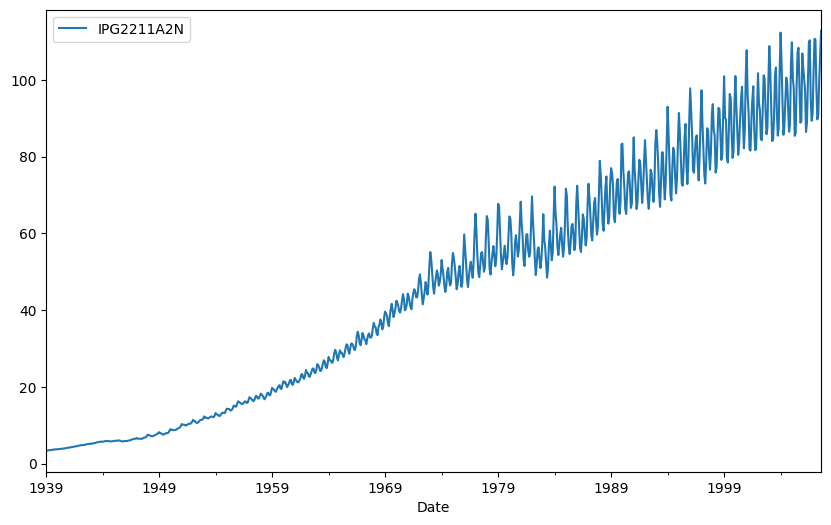

In [9]:
# Let's plot the dataframe to understand the trend of the data i.e. stationary or non-stationary

df_train.plot(figsize=(10, 6))


In [10]:
# Let's reconfirm that the data is stationay or not using Augmented Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    
    result = adfuller(data)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    if result[1] > 0.05:
        print("The data is non-stationary")
    else:
        print("The data is stationary")


In [11]:
adfuller_test(df_train)

ADF Statistic: 1.596644
p-value: 0.997847
The data is non-stationary


**Observations:**

Looking at the plot and Dickey-Fuller test results, we can say that the data in non-stationary.

---

##### **Data transformation to stationary by differencing**

In [12]:
# As the data is non stationary, let's apply differencing to make it stationary

df_train_diff = df.diff().dropna()

df_train_diff

,IPG2211A2N
Date,
1939-02-01,0.0255
1939-03-01,0.0763
1939-04-01,0.0254
1939-05-01,0.0000
1939-06-01,0.0509
...,...
2024-07-01,10.9360
2024-08-01,-1.6860
2024-09-01,-14.7279


In [13]:
adfuller_test(df_train_diff)

ADF Statistic: -10.345122
p-value: 0.000000
The data is stationary


<Axes: xlabel='Date'>

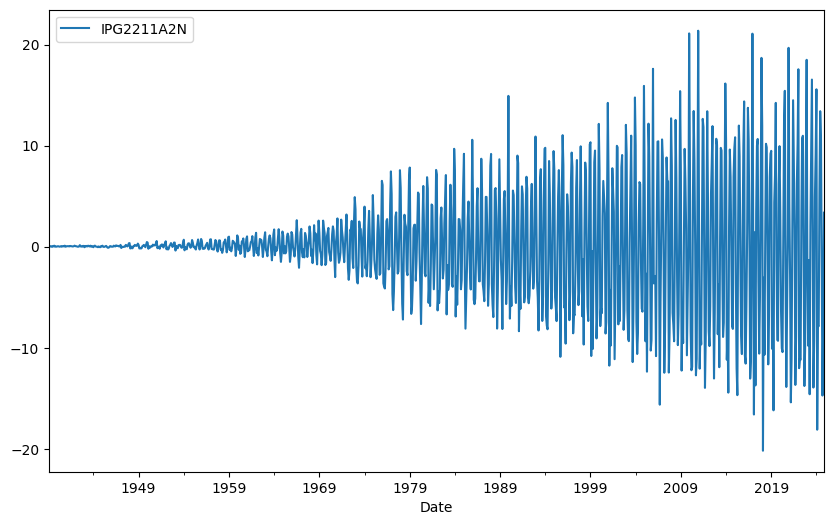

In [14]:
df_train_diff.plot(figsize=(10, 6))

**Observations:**

Looking at the above plot and Dickey-Fuller test results, now we can say that the data in stationary.

---

##### **Find p, q parameters for ARIMA model**

In [15]:
# To determine the order (p, d, q) of the ARIMA model, we will use the ACF and PACF plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


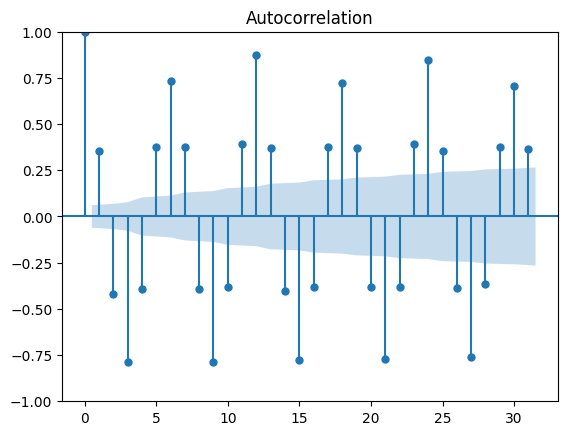

In [16]:
# Let's plot the auto correlation function 

plot_acf(df_train_diff)
plt.show()

**Observations:**

1. From your ACF plot, significant spikes are observed at lag 1, lag 2, and possibly lag 5.

2. This suggests q=1, q=2, or q=5, but q=1 is often chosen first for simplicity.

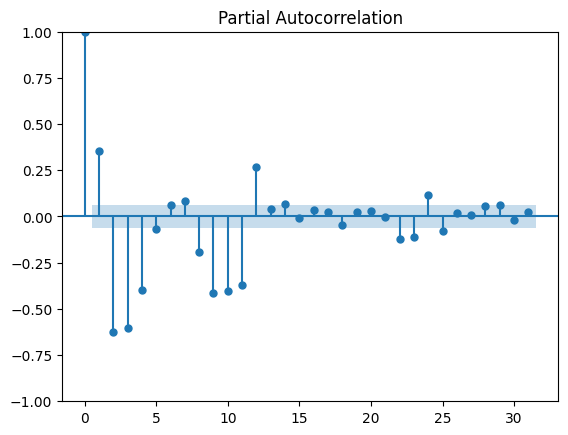

In [17]:
# Let's plot the partial auto correlation function 

plot_pacf(df_train_diff)
plt.show()

**Observations:**

1. From your PACF plot, significant spikes are observed at lag 1, and possibly at lag 4.

2. This suggests p=1 or p=4, but p=1 is typically chosen as the simpler model.

---

##### **Method 1 - Fit the ARIMA model**

In [18]:
# Let's fit the ARIMA model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train, order=(1, 1, 1), freq='MS')

model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  824
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2224.219
Date:                Tue, 07 Jan 2025   AIC                           4454.438
Time:                        23:17:06   BIC                           4468.577
Sample:                    01-01-1939   HQIC                          4459.862
                         - 08-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0569      0.040      1.406      0.160      -0.022       0.136
ma.L1          0.5585      0.030     18.457      0.000       0.499       0.618
sigma2        13.0233      0.409     31.804      0.0

c:\DevTools\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


##### **Predictions**

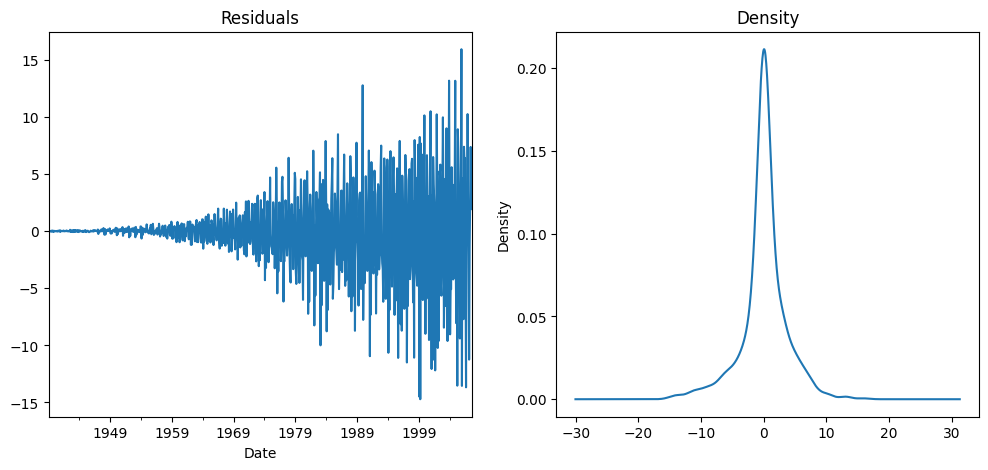

In [19]:
# Let's make predictions - first with the residuals

residuals = model_fit.resid[1:]

fig, ax = plt.subplots(1,2, figsize=(12, 5))

residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

plt.show()

**Observations:**

1. Residual looks similar to the data differencing plot.

2. Density is normally distributed with mean around 0.

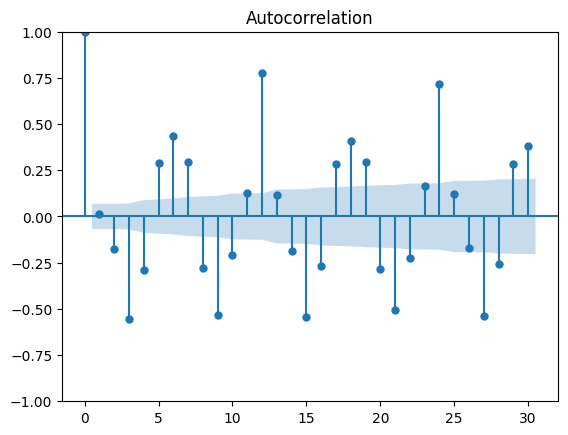

In [20]:
# Let's plot the auto correlation function

acf_res = plot_acf(residuals)
plt.show()

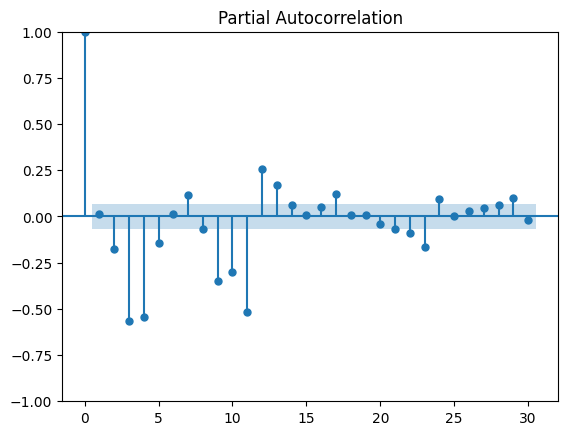

In [21]:
# Let's plot the partial auto correlation function 

pacf_res = plot_pacf(residuals)
plt.show()

In [22]:
# Let's forecast using the test data

forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df

,IPG2211A2N,forecast_manual
Date,,
1939-01-01,3.3336,NaN
1939-02-01,3.3591,NaN
1939-03-01,3.4354,NaN
1939-04-01,3.4608,NaN
1939-05-01,3.4608,NaN
...,...,...
2024-07-01,120.0696,116.151363
2024-08-01,118.3836,116.151363
2024-09-01,103.6557,116.151363


---

##### **Method 2 - Fit the Auto ARIMA model**

In [23]:
# Let's use auto_arima to find the best model

from pmdarima import auto_arima

auto_arima = auto_arima(df_train, stepwise=False, seasonal=False)

auto_arima


ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [24]:
# Lets get summary of the auto_arima model

print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  824
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1766.142
Date:                Tue, 07 Jan 2025   AIC                           3544.285
Time:                        23:17:13   BIC                           3572.562
Sample:                    01-01-1939   HQIC                          3555.133
                         - 08-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1228      0.069      1.775      0.076      -0.013       0.258
ar.L1          1.0002      0.001    834.304      0.000       0.998       1.003
ar.L2         -0.9993      0.001  -1016.576      0.0

##### **Predictions**

In [25]:
# Let's forecast using the test data

forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df

,IPG2211A2N,forecast_manual,forecast_auto
Date,,,
1939-01-01,3.3336,NaN,NaN
1939-02-01,3.3591,NaN,NaN
1939-03-01,3.4354,NaN,NaN
1939-04-01,3.4608,NaN,NaN
1939-05-01,3.4608,NaN,NaN
...,...,...,...
2024-07-01,120.0696,116.151363,138.941289
2024-08-01,118.3836,116.151363,137.683631
2024-09-01,103.6557,116.151363,128.202292


---

##### **Grid Search to find best parameters p, d, q**

In [26]:
# Let's manually iterate over combinations of p, d, and q to find the best model 
# based on a scoring metric like AIC (Akaike Information Criterion) or BIC.

import itertools
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

p = range(0, 6)  # AR terms
d = range(0, 2)  # Differencing terms
q = range(0, 6)  # MA terms

pdq_combinations = list(itertools.product(p, d, q))

ts = df_train

best_aic = np.inf
best_order = None
best_model = None

for order in pdq_combinations:
    try:        
        model = ARIMA(ts, order=order, freq='MS')
        fitted_model = model.fit()
        
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = order
            best_model = fitted_model
    except Exception as e:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

c:\DevTools\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\DevTools\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\DevTools\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\DevTools\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\DevTools\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Best ARIMA order: (5, 1, 5) with AIC: 3475.0449044515244


---

##### **Method 3 - Fit the ARIMA model using Grid Search Parameters**

In [27]:
# Let's fit the ARIMA model using the best order found

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_train, order=(5, 1, 5), freq='MS')

model_fit = model.fit()

print(model_fit.summary())

c:\DevTools\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  824
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1726.522
Date:                Tue, 07 Jan 2025   AIC                           3475.045
Time:                        23:17:52   BIC                           3526.887
Sample:                    01-01-1939   HQIC                          3494.934
                         - 08-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2724      0.341      0.799      0.424      -0.396       0.941
ar.L2          0.0262      0.309      0.085      0.933      -0.580       0.632
ar.L3         -0.6639      0.204     -3.248      0.0

In [28]:
# Let's forecast using the test data

forecast_test_grid = model_fit.forecast(len(df_test))

df['forecast_grid_serach'] = [None]*len(df_train) + list(forecast_test_grid)

df

,IPG2211A2N,forecast_manual,forecast_auto,forecast_grid_serach
Date,,,,
1939-01-01,3.3336,NaN,NaN,NaN
1939-02-01,3.3591,NaN,NaN,NaN
1939-03-01,3.4354,NaN,NaN,NaN
1939-04-01,3.4608,NaN,NaN,NaN
1939-05-01,3.4608,NaN,NaN,NaN
...,...,...,...,...
2024-07-01,120.0696,116.151363,138.941289,108.758692
2024-08-01,118.3836,116.151363,137.683631,106.576099
2024-09-01,103.6557,116.151363,128.202292,98.472378


---

##### **Model Evaluation**

In [29]:
# Let's calculate the metrics for the model where parameters were manually selected

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 14.905730074276537
mape - manual: 0.1561344989312004
rmse - manual: 17.400051557200708


In [30]:
# Let's calculate the metrics for the model where parameters were automatically selected using auto_arima

mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 15.30272391197748
mape - auto: 0.15324447971742508
rmse - auto: 16.805152528766737


In [31]:
# Let's calculate the metrics for the model where parameters were selected using grid search

mae = mean_absolute_error(df_test, forecast_test_grid)
mape = mean_absolute_percentage_error(df_test, forecast_test_grid)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_grid))

print(f'mae  - grid_search: {mae}')
print(f'mape - grid_search: {mape}')
print(f'rmse - grid_search: {rmse}')

mae  - grid_search: 3.9760150640593133
mape - grid_search: 0.03804312199655938
rmse - grid_search: 5.117388078065361


---

##### **Visualizing the best ARIMA model prediction**

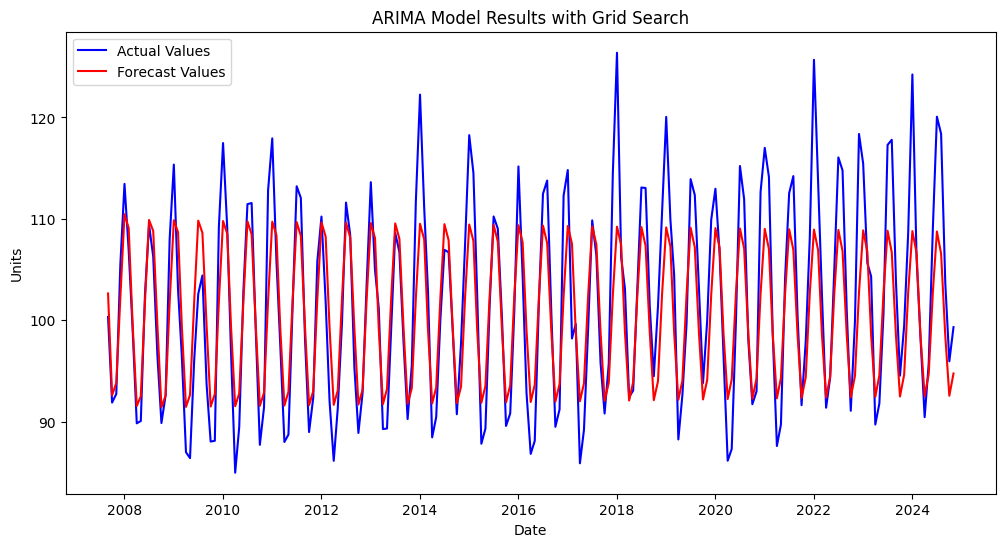

In [32]:
# Plotting the test results of the best model - Model with Grid Search Parameters

plt.figure(figsize = (12, 6))

plt.plot(df['IPG2211A2N'][len(df_train):], color = 'blue', label = 'Actual Values')
plt.plot(df['forecast_grid_serach'][len(df_train):], color = 'red', label = 'Forecast Values')
plt.title('ARIMA Model Results with Grid Search')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()

---

#### **Conclusion:**

The results indicate that the optimized ARIMA model, with parameters obtained through grid search, outperforms the other models, including the baseline ARIMA and Auto ARIMA. Notably, the optimized ARIMA model achieves significantly lower scores for Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE). These metrics demonstrate the model's superior predictive accuracy and reliability, making it the preferred choice for future forecasting tasks.

---